# Practical 4 - Dimensionality Reduction and Clustering

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(context='talk',style='white',palette='colorblind')
import pickle
import scipy
import matplotlib
from scipy import sparse
import sklearn
import sklearn.mixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import scipy as sp

## Task 0: Load and normalize count data

This practical uses the data set from https://www.nature.com/articles/s41586-018-0654-5. This is single cell transcriptomics data from ~25,000 cells from the cortex. 

For each of these cells, the expression of several thousand genes was measured ```['counts']```. In the original study, the authors were interested in clustering the cells into types. 

We made a selection of 5000 cells and the 1000 most informative genes for run time reasons. We provide you with the original cell type labels determined by the authors for comparison ```['clusters']```.

The following function will apply some preprocessing steps that are standard for transcriptomics data.

In [2]:
def lognormalize_counts(tasic_dict):
    
    #normalize and logtransform counts
    counts = tasic_dict['counts']
    libsizes = counts.sum(axis=1)
    CPM = counts / libsizes * 1e+6
    logCPM = np.log2(CPM + 1) 
    tasic_dict['logCPM'] = np.array(logCPM)  
    
    return tasic_dict

In [3]:
tasic_1k = lognormalize_counts(
    pickle.load(open('tasic_subset_1kselected.pickle','rb')))

In [4]:
np.shape(tasic_1k)
tasic_1k['counts']


<5000x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 937979 stored elements in Compressed Sparse Column format>

In [5]:
print(np.shape(tasic_1k['genes']))
print(np.shape(tasic_1k['counts']))
print(np.shape(tasic_1k['clusters']))
print(np.shape(tasic_1k['logCPM']))
print(np.shape(tasic_1k))

(1000,)
(5000, 1000)
(5000,)
(5000, 1000)
()


In [6]:
tasic_1k['areas']
#tasic_1k

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

Have a look at ```['counts']```, ```['logPCM']``` and ```['clusters']``` to get a better understanding of the data.

## Task 1: Linear dimensionality reduction with PCA

In this task, you will use Principal Component Analysis (PCA) to reduce the dimensionality of the dataset.

First, implement PCA "by hand". You can use eigenvalue/singular value decomposition from numpy/scipy but no `sklearn`-functions. Write a function that computes all possible principal components and returns them along with the fraction of variance they explain.

In [7]:
def PCA_manual(data):
    '''
    Function that performs PCA on the input data
    
    input: (cells, genes)-shaped array of log transformed cell counts
    output:
        fraction_variance_explained: (genes,)-shaped array with the fraction of variance explained by the individual PCs
        principal_components: (genes, genes)-shaped array containing the principal components as columns
    '''
    ### NOTE: Make sure the function returns the PCs sorted by the fraction of variance explained! ###
    ###       (First column of principal_components should hold the PC with the highest variance   ###
    ###       explained -- fraction_variance_explained should also be sorted accordingly)          ###

    
    # ---------------- INSERT CODE ----------------------
    
    #Step 1: calculate the mean values of each column
    
    mean_per_column = np.mean(data.T, axis = 1)
    
    
    # Step 2: center columns matrix by subtracting column means
    center_columns = data- mean_per_column
    
    # Step 3: Calculate the covariance matrix
    COV = np.cov(center_columns.T)

    #step 4:Find the eigenvalues and eigenvectors of the covariance matrix
    eigval,eigvec = np.linalg.eig(COV)
    
    for ev in eigvec:
        np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
   
    
    # Step 4.1 Make a list of (eigenvalue, eigenvector) tuples
    eigpairs = [(np.abs(eigval[i]),eigvec[:,i]) for i in range(len(eigval))]

    
    # Step 5: Calculate explained variance:
    
    total = sum(eigval)
    
    fraction_variance_explained = []
    
    for i in eigval:
        fraction_variance_explained.append((i / total)*100)
    
    
    #Step 5: Use the principal components to transform the data - Reduce the dimensionality of the data
    principal_components = eigvec.T
    
    
    # ---------------- END CODE -------------------------

    
    return fraction_variance_explained, principal_components


In [8]:
var_expl, PCs = PCA_manual(tasic_1k['logCPM'])
print(np.shape(PCs))
print(np.shape(var_expl))
#print(var_expl)
#print(PCs)

(1000, 1000)
(1000,)


Before we explore the structure of the low-dimensional representation, we first want to know how much variance the first PCs explain: 

- Plot the fraction of variance explained by the `n`-th PC vs. `n`

- Plot the cumulative fraction of variance explained by the first `n` PCs with largest eigenvalue vs. `n`

From the latter plot you should be able to see how many PCs you need to keep to explain at least `x`% of the variance.

How many components do you need to keep to explain 50%, 75%, 90% and 99%, respectively? Indicate this in your plot.

Text(0, 0.5, 'cumulative explained variance')

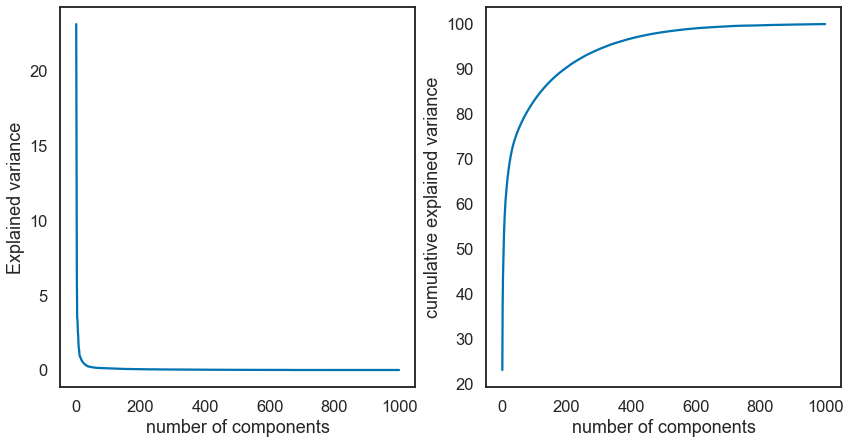

In [9]:
#import chart_studio.plotly as py
p = []

for i in range(1,1001):
    p.append(i)

plt.figure(figsize=(14,7))
plt.subplot(121)


# ---------------- INSERT CODE ----------------------
# Plot the variance explained of the n-th PC vs. n
plt.plot(p,var_expl)
plt.xlabel('number of components')
plt.ylabel('Explained variance')

# Plot the cumulative variance explained for the n PCs with highest variance explained vs. n
# Indicate how many components you need to keep to explain 50%, 75%, 90% and 99% in the plot.

cumalative_variance_explained = np.cumsum(var_expl)

plt.subplot(122)
plt.plot(p,cumalative_variance_explained)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
# ---------------- END CODE -------------------------


No handles with labels found to put in legend.


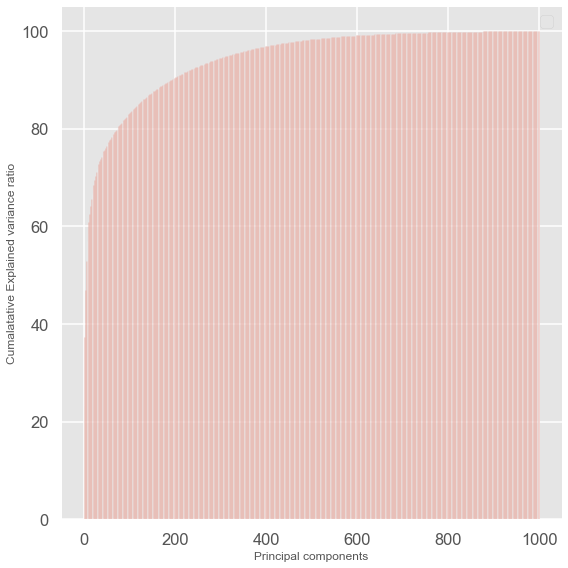

In [10]:
with plt.style.context('ggplot'):
    plt.figure(figsize=(8,8))

    plt.bar(range(1000),cumalative_variance_explained, alpha=0.5)
   
    plt.ylabel('Cumalatative Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

YOUR ANSWER HERE: 50% : 40-50 Components
                  75% : more than 100 Components
                  90% : Almost 300 Components
                   99% : 600-700 Components

Write a function to select the `n` PCs needed to explain at least `x`% of the variance and use this function to extract as many PCs as are needed to explain 75% of the variance. 

In [11]:
def select_PCs(
    variance_explained, principal_components, percent_variance):
    '''Function that selects the first n principal components necessary to explain x% of the variance
    input: 
        variance_explained: amount of variance explained by the individual PCs
        principal_components: contains the principal components as columns
        percent_variance: fraction of the variance, the all PCs that are kept explain
    output:
        variance_explained_kept: individual amount of variance explained for the remaining PCs
        principal_components_kept: remaining principal components, shape (genes,n_PCs_kept)
                
    '''
  
    # ---------------- INSERT CODE ----------------------
   
    num = percent_variance*len(principal_components[:])
    num = int(num)
        
    principal_components_kept = [principal_components[:,i] for i in range(num)]  
    variance_explained_kept = [variance_explained[i] for i in range(num)] 
    
    principal_components_kept = np.array(principal_components_kept)
    variance_explained_kept = np.array( variance_explained_kept)
    
   # ---------------- END CODE -------------------------
            
    return variance_explained_kept, principal_components_kept

In [12]:
VE75, PCs75 = select_PCs(var_expl, PCs, percent_variance=0.75)
#VE75
print(np.shape(PCs75))
#PCs75
print(np.shape(VE75))
#PCs75

(750, 1000)
(750,)


To compute the representation of the data in this lower dimensional representation, write a function that compute the PC scores for each cell, i.e. that projects the original data matrix on the low-dimensional subspace provided by the first `n` PCs:

In [13]:
def compute_PCA_scores(data, principal_components):
    '''Function that returns the PC scores for each data point
    input: 
        data                 --- (cells,genes)-shaped array of log transformed cell counts
        principal_components --- contains the principal components as columns\
    output:
        pc_scores            --- (cells,n_PCs_kept)-shaped array of PC scores
    
    ''' 
    #---------------- INSERT CODE ----------------------
    
    mean_per_column = np.mean(data.T, axis = 1)
    center_columns = data- mean_per_column
    pc_scores = np.dot(center_columns,principal_components.T)
    
    
    #---------------- END CODE -------------------------

    return pc_scores

In [14]:
tasic_1k['PCA_75'] = compute_PCA_scores(tasic_1k['logCPM'], PCs75)
np.shape(tasic_1k['PCA_75'])

(5000, 750)

Visualize the top 5 PCs as a pairwise scatterplot. Use one subplot for each pair of components.

Use the colors provided in `tasic_1k['clusterColors']` and the cluster information in `tasic_1k['clusters']` to color each data point according to its original cluster identity.

If you're familiar with Pandas dataframes and seaborn, this plot can be generated easily. Alternatively you can also do it "by hand" using matplotlib.

The colors indicate the family of the cell type:

- greenish colors: excitatory neurons
- orange colors: somatostatin positive interneurons
- pinkish colors: VIP-postive interneurons
- reddish colors: parvalbumin positive interneurons
- dark colors: non-neurons (glia etc)

What do you observe?

In [15]:
#tasic_1k['clusterColors']

In [16]:
color_per_datapoint = tasic_1k['clusterColors'][tasic_1k['clusters']]
np.shape(color_per_datapoint)

(5000,)

In [17]:
import pandas as pd

def plot_PCs(data_transformed, color_per_datapoint):
    '''Function that plots the scores of the 10 pairs of the top 5 PCs against each other.
        inputs:
            data_transformed    -- (cells,n_PCs_kept)-shaped array of PC scores
            color_per_datapoint -- (cells,)-shaped array of color strings, one color for each cell
    '''
   
    
    #---------------- INSERT CODE ----------------------
    p_df = data_transformed[:,0:5]
    t_df = pd.DataFrame(p_df)
    
    t_df["y"] = pd.DataFrame(color_per_datapoint)
    
    #sns.pairplot(t_df,hue="y")
    sns.pairplot(t_df, hue = 'y', diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
             size = 4)
    
    # ---------------- END CODE -------------------------

C:\Users\kanik\anaconda3\lib\site-packages\seaborn\axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\kanik\anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\kanik\anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\kanik\anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\kanik\anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\kanik\anaconda3\lib\site-packages\seaborn\distributions.py:288: UserWar

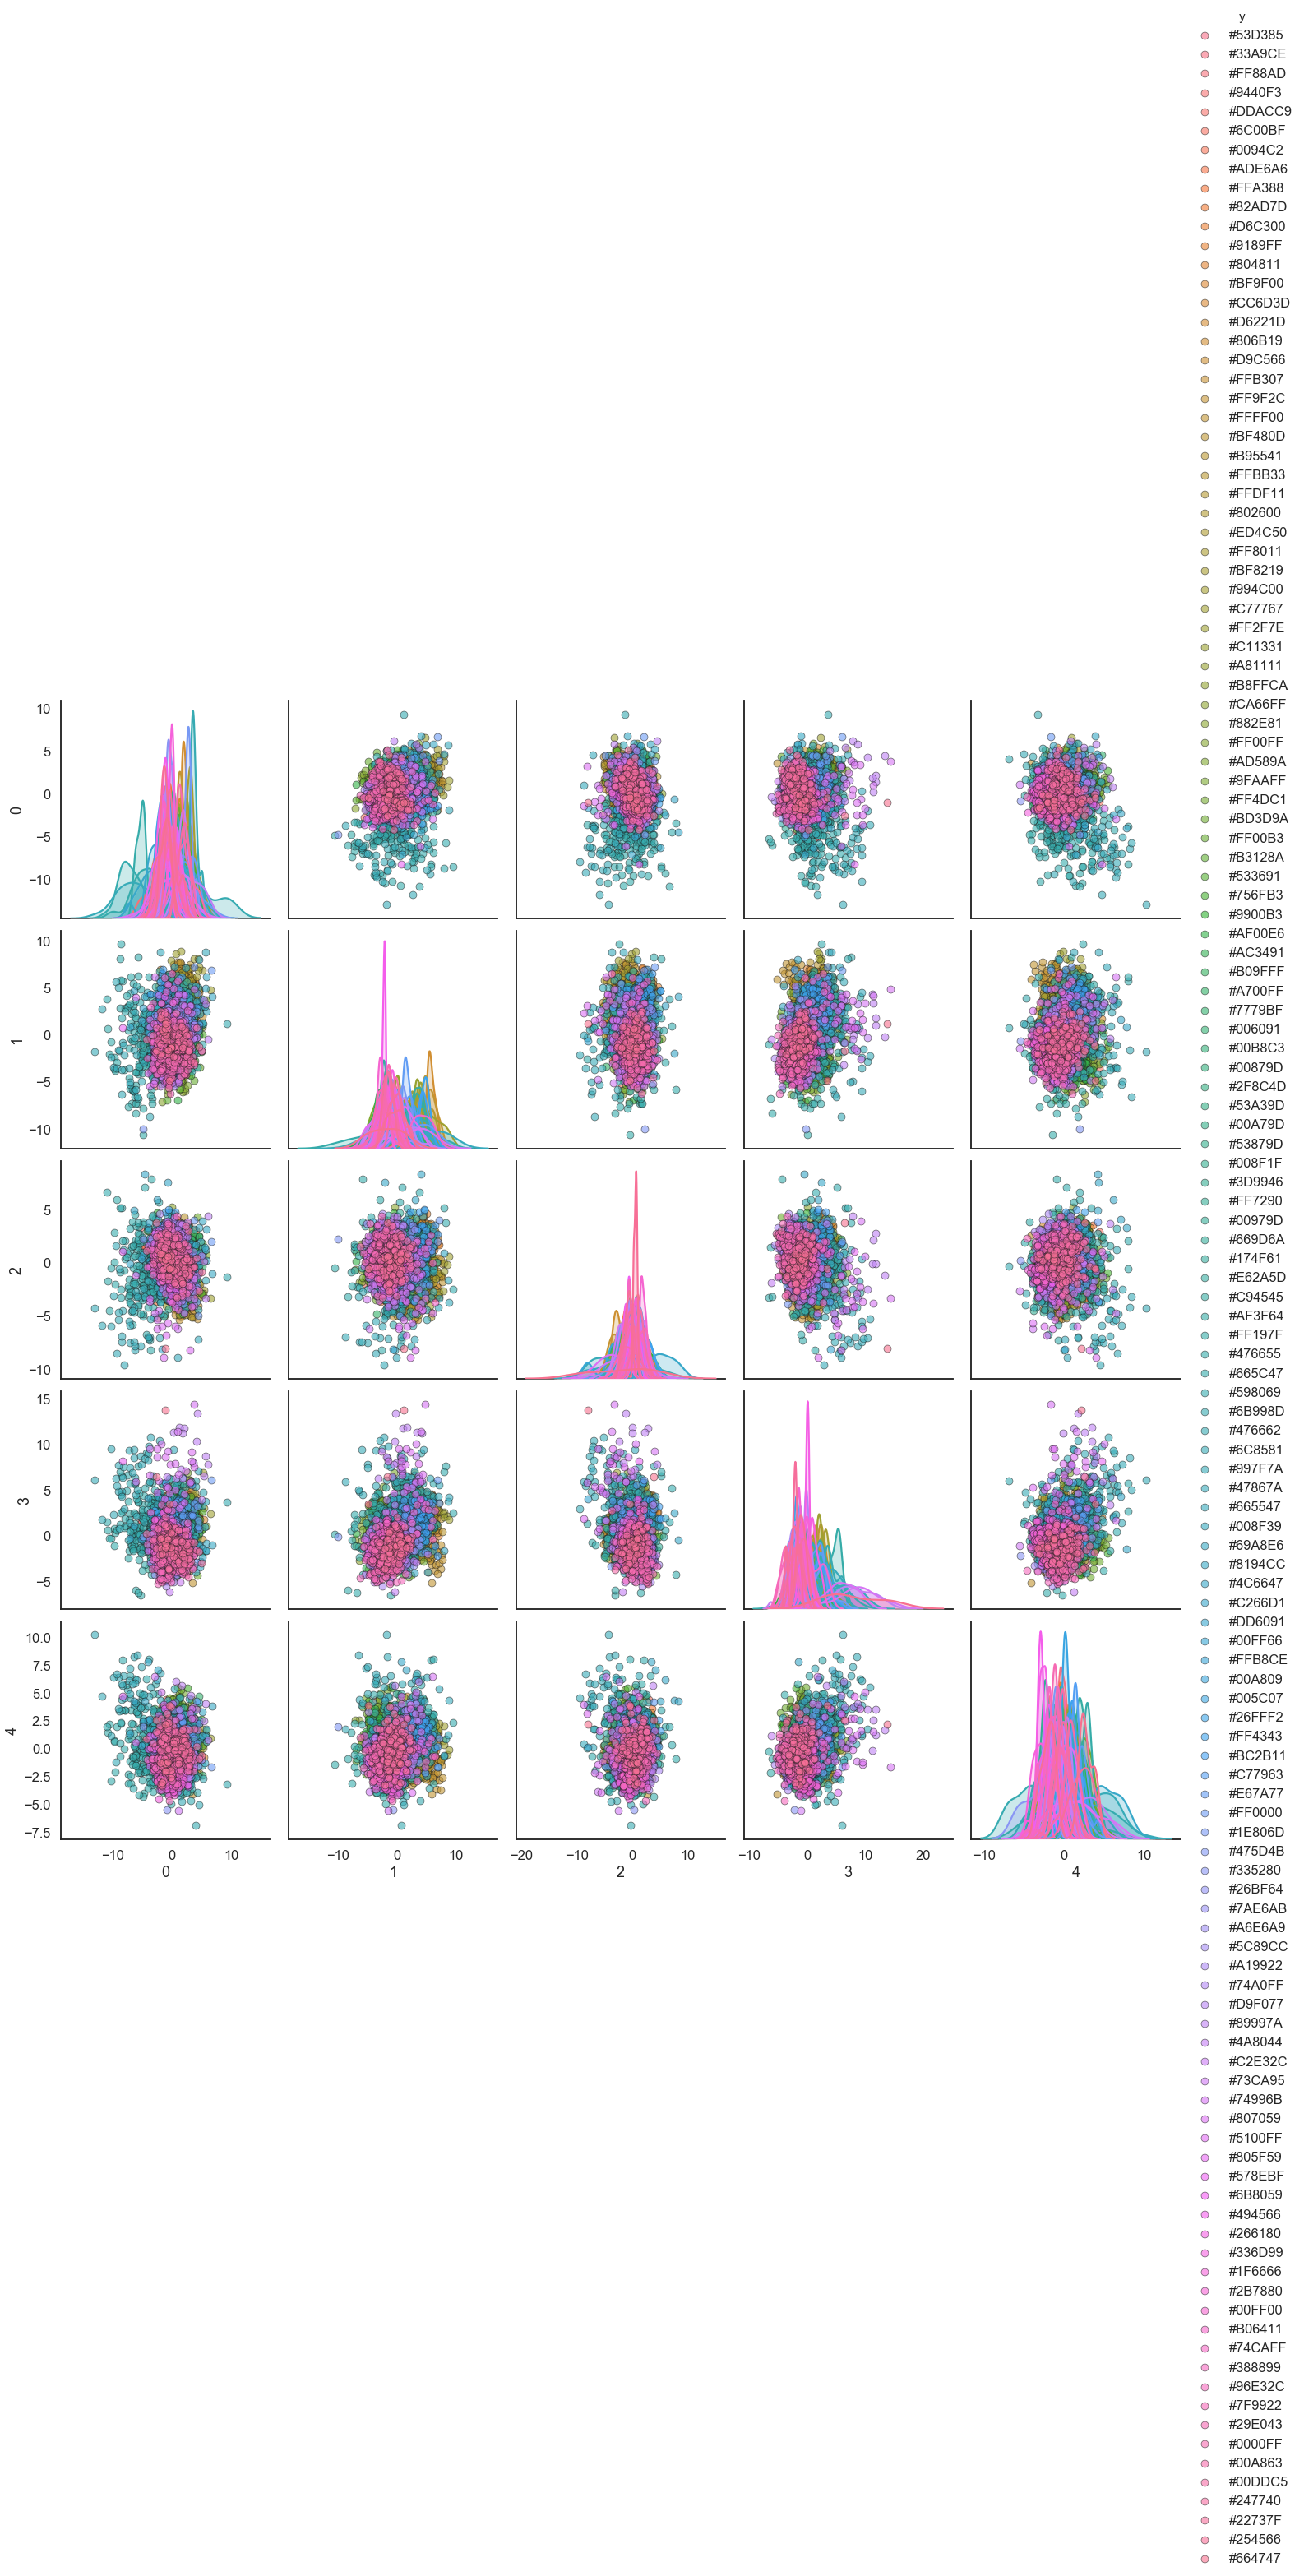

In [18]:
color_per_datapoint = tasic_1k['clusterColors'][tasic_1k['clusters']]
plot_PCs(tasic_1k['PCA_75'], color_per_datapoint)

YOUR ANSWER HERE

## Task 2: Comparison with PCA implemented by sklearn

Use the PCA implementation of sklearn to check whether your PCA implementation is correct and obtain some insights into numerical precision of the algorithms underlying PCA implementations.

In [19]:
from sklearn.decomposition import PCA

def PCA_sklearn(data):
    '''
    Function that performs PCA on the input data, using sklearn
    
    input: (cells,genes)-shaped array of log transformed cell counts
    output:
        fraction_variance_explained: (genes,)-shaped array with the fraction of variance explained by the individual PCs
        principal_components: (genes,genes)-shaped array containing the principal components as columns
    '''

    # ---------------- INSERT CODE ----------------------
   
    pca = PCA()
    pca.fit(data)
    
    fraction_variance_explained = pca.explained_variance_
    principal_components = pca.components_ 
    
    
    
    # ---------------- END CODE -------------------------
    
    return fraction_variance_explained, principal_components

In [20]:
    pca = PCA(n_components=750)
    pca.fit(tasic_1k['logCPM'])
    
    fraction_variance_explained = pca.explained_variance_
    principal_components = pca.components_ 
    

In [21]:
np.shape(principal_components)
np.shape(fraction_variance_explained)

(750,)

In [22]:
#do sklearn-PCA on selected genes
var_expl_sklearn, PCs_sklearn = PCA_sklearn(tasic_1k['logCPM'])
#select components as before

var_expl_sklearn75, PCs_sklearn75 = select_PCs(var_expl_sklearn, PCs_sklearn, 0.75)
#get PC scores

PCA_75_sklearn = compute_PCA_scores(tasic_1k['logCPM'], PCs_sklearn75)

In [23]:
PCA_75_sklearn.shape

(5000, 750)

In [24]:
#print(var_expl_sklearn)
#print(PCs_sklearn)
#print(var_expl_sklearn)
#print(cve_sklearn)
np.shape(PCA_75_sklearn)
#print(PCs_sklearn75)
#print(var_expl_sklearn75)

(5000, 750)

In [25]:
print(np.shape(VE75))
print(np.shape(var_expl_sklearn75))

(750,)
(750,)


To see if your manual PCA yielded the same PC weights as the sklearn PCA, we can just take the two matrices of principal components and plot their entries against each other. (Note: This again assumes they are sorted by variance explained..)

Use the following plot to compare the results to your own implementation (here plotting the weights of the first 100 PCs against each other). What do you observe?

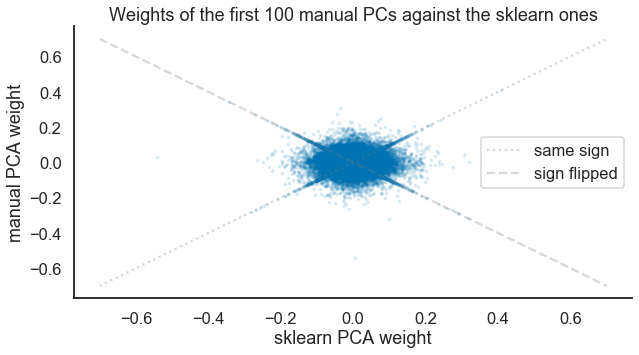

In [26]:
n_evs_to_compare = 100
    
plt.figure(figsize=(10, 5))
plt.scatter(PCs_sklearn[:,:n_evs_to_compare].flatten(), 
            PCs[:,:n_evs_to_compare].flatten(), s=5, alpha=0.1)
plt.plot([-.7,.7], [-.7,.7], ':', c='tab:gray', label='same sign', alpha=0.3)
plt.plot([-.7,.7], [.7,-.7], '--', c='tab:gray', label='sign flipped', alpha=0.3)
plt.legend()
plt.xlabel('sklearn PCA weight')
plt.ylabel('manual PCA weight')
plt.title('Weights of the first %u manual PCs against the sklearn ones' % (n_evs_to_compare))

sns.despine()

YOUR ANSWER HERE

Additional reading about the sign of PCs: https://stats.stackexchange.com/questions/88880/does-the-sign-of-scores-or-of-loadings-in-pca-or-fa-have-a-meaning-may-i-revers

## Task 3: Nonlinear dimensionality reduction with t-SNE

In this task, you will use the nonlinear dimensionality reduction technique tSNE and look at visualizations of the data set. First, run the default t-SNE and store the result in a variable you keep, as you will use it for plotting in the next tasks as well. Plot the result of default t-SNE with the original cluster colors. For this and the following tasks, use the PCs explaining 75% of the variance ```PCA_75_sklearn``` you computed above.

In [27]:
def plot_tsne(tsne_results, clusters=tasic_1k['clusters'], labels=['']):
    '''Plotting function for tsne results, creates one or multiple plots of tSNE-transformed data.
       If the clustering is the original one (default), original cluster colors will be used. Otherwise,
       colors will be a random permutation.
    
    input:
        tsne_results: (n, 2)-shaped array containing tSNE-transformed data or list of such arrays
                      (output of the fit_transform function of sklearn tSNE)
        clusters: (n,)-shaped array containing cluster labels or list of such arrays
        labels: optional, list of titles for the subplots
    '''
    
    if type(tsne_results)==list: # make sure we can do both single and multiple plots and are flexible regarding input
        num_plots = len(tsne_results)
    else:
        num_plots = 1
        tsne_results = [tsne_results]
    if type(clusters)==list:
        num_clusters = len(clusters)
        num_plots = num_plots * num_clusters
        tsne_results = tsne_results * num_clusters
    else:
        clusters = [clusters]*num_plots
    
    if len(labels)==1:
        labels = labels*num_plots
        
    n_clusters = len(np.unique(clusters))      # ensure a long enough color list even if we plot more than 
    n_colors = len(tasic_1k['clusterColors'])  # the original number of clusters
    if n_clusters > n_colors:
        n_extra_colors = n_clusters - n_colors
        colors = np.concatenate((tasic_1k['clusterColors'],tasic_1k['clusterColors'][:n_extra_colors]))    
    else:
        colors = tasic_1k['clusterColors']

    fig, ax = plt.subplots(num_plots,1,figsize=(10,num_plots*10))
    if num_plots==1:
        if not np.all(tasic_1k['clusters']==clusters[0]):
            current_colors = np.random.permutation(colors)
        else:
            current_colors = colors
        ax.scatter(tsne_results[0][:,0], tsne_results[0][:,1], s=1, color=current_colors[clusters[0]])
        ax.set_title(labels[0])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_axis_off()
    else:
        for i in range(num_plots):
            if not np.all(tasic_1k['clusters']==clusters[i]):
                current_colors = np.random.permutation(colors)
            else:
                current_colors = colors
            ax[i].scatter(tsne_results[i][:,0], tsne_results[i][:,1], s=1, color=current_colors[clusters[i]])
            ax[i].set_title(labels[i])
            ax[i].set_xticks([])
            ax[i].set_yticks([])
            ax[i].set_axis_off()
            
            

Run the following cells to set the random seed/random state, run tSNE and plot the results.

In [28]:
tsne_default = TSNE(random_state=1)
tsne_results = tsne_default.fit_transform(PCA_75_sklearn)
original_clusters = tasic_1k['clusters']

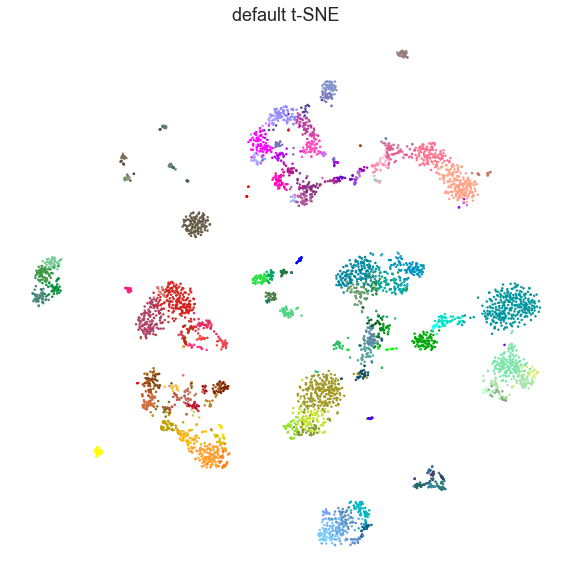

In [29]:
plot_tsne(tsne_results, original_clusters, labels=['default t-SNE'])

t-SNE has one main parameter called perplexity, which trades of local and global structure. Its default value is 30. Run the tSNE with some other perplexity values (e.g. 5, 100), plot the results next to each other and explain what you observe. In particular, compare with the PCA plot above.

In [30]:
# try different perplexities
# ---------------- INSERT CODE ----------------------
    
tsne5 = TSNE(perplexity=5,random_state=1)  
tsne_results5 = tsne5.fit_transform(PCA_75_sklearn)
original_clusters5 = tasic_1k['clusters']

tsne100 = TSNE(perplexity=100,random_state=1)  
tsne_results100 = tsne100.fit_transform(PCA_75_sklearn)
original_clusters100 = tasic_1k['clusters']
    
# ---------------- END CODE -------------------------


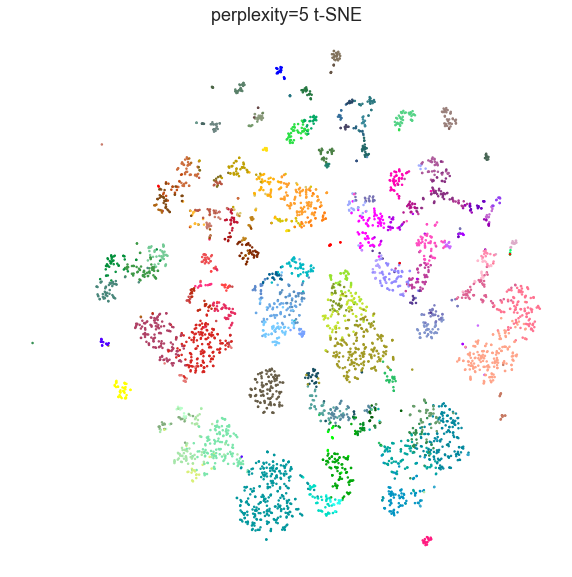

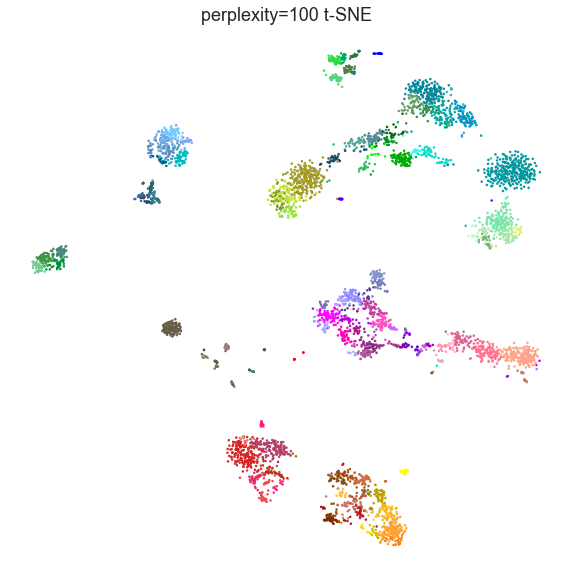

In [31]:
# plot results
# ---------------- INSERT CODE ----------------------
plot_tsne(tsne_results5, original_clusters5, labels=['perplexity=5 t-SNE'])
plot_tsne(tsne_results100, original_clusters100, labels=['perplexity=100 t-SNE'])
    
    
# ---------------- END CODE -------------------------

YOUR ANSWER HERE: A higher perplexity gives a plot where the clusters are further apart and the points within the clusters a nearer to each other

## Task 4: Cluster the data using k-Means

So far, we only visualized the data and plotted it with the original cluster labels. As a next step, we will implement k-Means as an example of a simple clustering algorithm and see how it performs on the dataset. 

Use the function KMeans provided by sklearn to perform K-Means with different numbers of clusters, for instance 5, 10, 20 and 50. Use the PCs explaining 75% of the variance ```PCA_75_sklearn``` you computed above.

In [51]:
def run_KMeans(data, n_clusters):
    '''Function that performs K-means clustering for a given number of clusters
        input: 
            data: (cells,genes)-shaped array of log transformed cell counts
            number of clusters: int, number of clusters
        output: 
            kmeans_result: (N,)-shaped array of integers that hold the cluster assignment for each data point
    '''
    
    # ---------------- INSERT CODE ----------------------
    kmeans = KMeans(n_clusters=5, random_state=0)
    kmeans_result=kmeans.fit_predict(data,PCA_75_sklearn)    
    
    
    # ---------------- END CODE -------------------------   
    return kmeans_result

In [52]:
# run kmeans
# ---------------- INSERT CODE ----------------------
laenge=len(tasic_1k['clusters'])
results=run_KMeans(tasic_1k['logCPM'], laenge)
results
    
# ---------------- END CODE -------------------------

array([0, 0, 1, ..., 2, 2, 2])

Plot your results as cluster labels in the tSNE map and compare it to the original cluster labels. Describe your results.

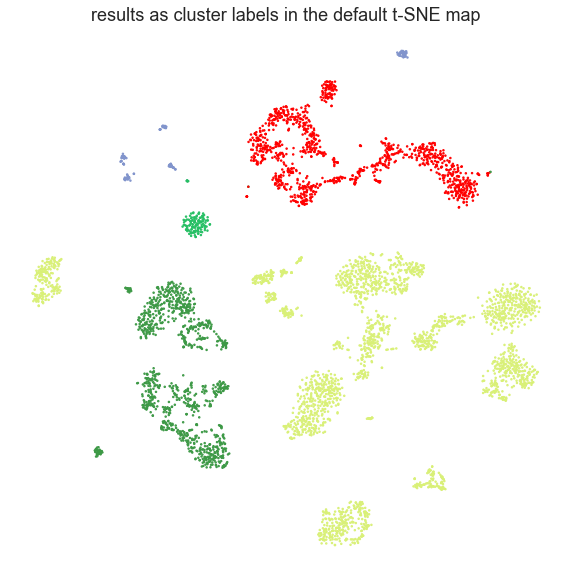

In [56]:
# plot results
# ---------------- INSERT CODE ----------------------
plot_tsne(tsne_results, results, labels=['results as cluster labels in the default t-SNE map'])  
    
# ---------------- END CODE -------------------------

YOUR ANSWER HERE: It is the same plot only with less colors.

##  Task 5: Clustering using Gaussian Mixture Models

Finally, we will implement clustering with Gaussian Mixture models ss discussed in the Bishop in Chapter 9.2.2 pg. 435-439. 

To this end, we will first generate toy data to later verify the correct implementation of the algorithm and then implement the algorithm using EM and run it on the transcriptomics data set. 

To generate the toy data, we sample 1000 data points from a two dimensional mixture of Gaussian model with three clusters  and the following parameters:

$\mu_1 = \begin{bmatrix}0\\0\end{bmatrix}, \Sigma_1 = \begin{bmatrix}1 & 0\\0 & 1\end{bmatrix}, \pi_1=0.3$

$\mu_2 = \begin{bmatrix}5\\1\end{bmatrix}, \Sigma_2 = \begin{bmatrix}2 & 1\\1 & 2\end{bmatrix}, \pi_2=0.5$

$\mu_4 = \begin{bmatrix}0\\2\end{bmatrix}, \Sigma_3 = \begin{bmatrix}1 & -0.5\\-0.5 & 1\end{bmatrix}, \pi_3=0.2$

In [35]:
def sampleData(N, means, covs, priors):
    '''Generate N samples from a Mixture of Gaussian distribution.
    
    inputs:
        N           -- number of samples
        means       -- (n_cluster,n_features)-shaped array of mean vectors
        covs        -- (n_features,n_features,n_cluster)-shaped array of covariance matrices
        prioirs     -- (n_cluster)-shaped arrays of priors / mixing coefficients
    outputs:
        data        -- (N,n_features)-shaped array of simulated data
        cluster_ids -- (N,)-shaped array of integers that hold the cluster assignment for each data point

    '''
    
    n_components = priors.shape[0]
    n_dimensions = covs.shape[0]
    
    n_samples = (N*priors).astype(int)
    n_samples_cumsum = np.cumsum(n_samples)
   
    data = np.zeros((sum(n_samples),n_dimensions))*np.nan
    cluster_ids = np.zeros((N))*np.nan
    
        
    for i,(n_sample, n_total_samples) in enumerate(zip(n_samples, n_samples_cumsum)):
        #sample for one component and save results
        start_idx = n_total_samples-n_sample
        end_idx = n_total_samples
        data[start_idx:end_idx,:] = np.random.multivariate_normal(means[i,:], covs[:,:,i], int(n_sample))
        cluster_ids[start_idx:end_idx] = i*np.ones((int(n_sample)))
    
    return data, cluster_ids 

In [36]:
# set up sampling
N = 1000
toy_means = np.array([[0, 0], [5, 1], [0, 4]])
toy_cov1 = np.array([[1, 0], [0, 1]])
toy_cov2 = np.array([[2, 1], [1, 2]])
toy_cov3 = np.array([[1, -.5], [-.5, 1]])
toy_covs = np.concatenate((toy_cov1[:,:,np.newaxis],
                    toy_cov2[:,:,np.newaxis],
                    toy_cov3[:,:,np.newaxis]), axis=2)
toy_priors = np.array([.3, .5, .2])   

toy_data, toy_cluster_ids_true = sampleData(N, toy_means, toy_covs, toy_priors)

Plot the sampled data points and indicate in color the cluster each point came from. Plot the cluster means as well.

In [41]:
def plot_clustering(data, cluster_ids, means, title):
    '''
    Plots the (2D) data as scatter plot, with different colors and an extra symbol for the mean per cluster.
    inputs:
        data        -- (N,n_features)-shaped array of data
        cluster_ids -- (N,)-shaped array of integers that hold the cluster assignment for each data point
        means       -- (n_cluster,n_features)-shaped array of mean vectors
        title       -- string that is added as title

    '''
    
    # ---------------- INSERT CODE ----------------------
    kmeans = KMeans(3, random_state=0)
    labels = kmeans.fit(data).predict(data)
    plt.scatter(data[:, 0], data[:, 1], c=labels, s=40, cmap='viridis')
    plt.scatter(means[:,0], means[:,1], color='r', marker='*')
    plt.show()    
    
    
    # ---------------- END CODE -------------------------  



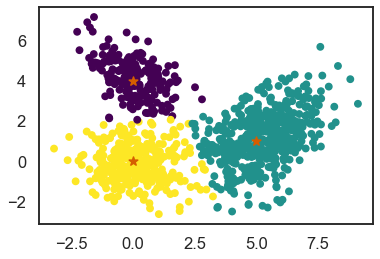

In [42]:
plot_clustering(toy_data, toy_cluster_ids_true, toy_means, 'Toy dataset: Ground truth')

Implement the EM algorithm to fit a Gaussian mixture model on the PCA-transformed data. Sort the data points by inferring their class labels from your mixture model (by using maximum a-posteriori classification). Fix the seed of the random number generator to ensure deterministic and reproducible behavior. 

For this task, it is important to think about a good way to initialize the means, covariances and mixing coefficients. Also, during optimization, covariance matrices can become singular. To prevent this, you can add a small constant (like $10^{-5}$) to the diagonal.

In order to speed up the computation, define a convergence criterion that stops the algorithm after convergence.

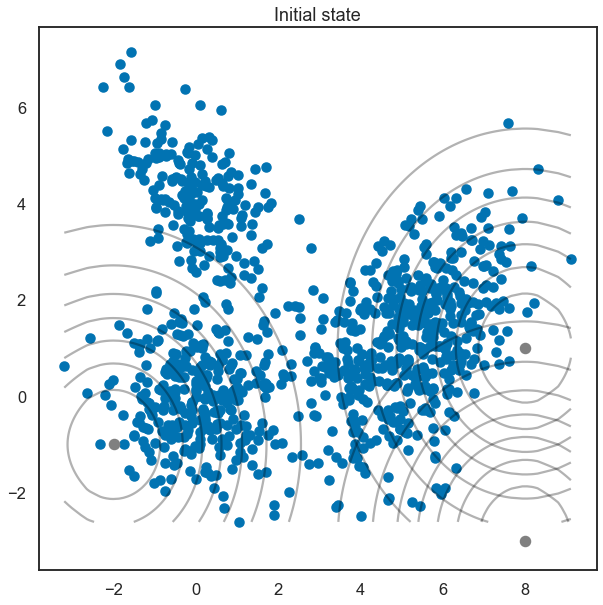

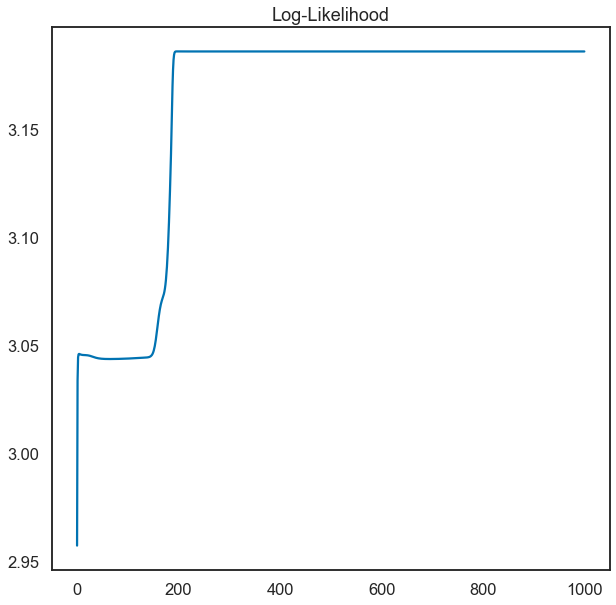

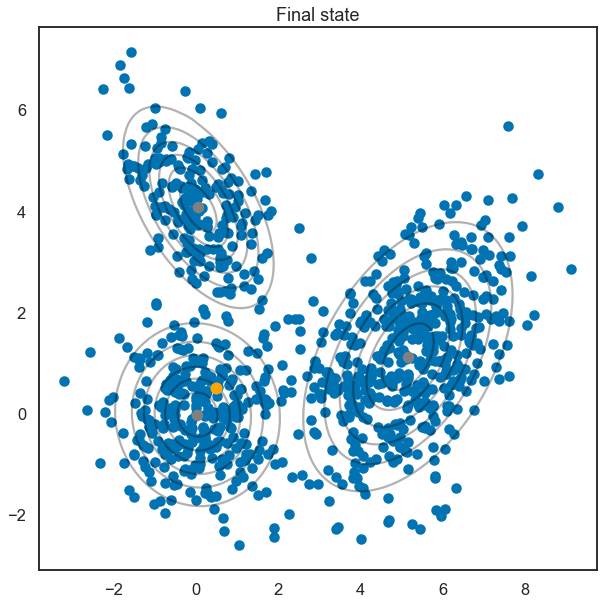

In [43]:
from scipy.stats import multivariate_normal
X = toy_data
class GMM:

    def __init__(self,X,number_of_sources,iterations):
        self.iterations = iterations
        self.number_of_sources = number_of_sources
        self.X = X
        self.mu = None
        self.pi = None
        self.cov = None
        self.XY = None
        
    

    """Define a function which runs for iterations, iterations"""
    def run(self):
        self.reg_cov = 1e-6*np.identity(len(self.X[0]))
        x,y = np.meshgrid(np.sort(self.X[:,0]),np.sort(self.X[:,1]))
        self.XY = np.array([x.flatten(),y.flatten()]).T
           
                    
        """ 1. Set the initial mu, covariance and pi values"""
        self.mu = np.random.randint(min(self.X[:,0]),max(self.X[:,0]),size=(self.number_of_sources,len(self.X[0]))) # This is a nxm matrix since we assume n sources (n Gaussians) where each has m dimensions
        self.cov = np.zeros((self.number_of_sources,len(X[0]),len(X[0]))) # We need a nxmxm covariance matrix for each source since we have m features --> We create symmetric covariance matrices with ones on the digonal
        for dim in range(len(self.cov)):
            np.fill_diagonal(self.cov[dim],5)


        self.pi = np.ones(self.number_of_sources)/self.number_of_sources # Are "Fractions"
        log_likelihoods = [] # In this list we store the log likehoods per iteration and plot them in the end to check if
                             # if we have converged
            
        """Plot the initial state"""    
        fig = plt.figure(figsize=(10,10))
        ax0 = fig.add_subplot(111)
        ax0.scatter(self.X[:,0],self.X[:,1])
        ax0.set_title('Initial state')
        for m,c in zip(self.mu,self.cov):
            c += self.reg_cov
            multi_normal = multivariate_normal(mean=m,cov=c)
            ax0.contour(np.sort(self.X[:,0]),np.sort(self.X[:,1]),multi_normal.pdf(self.XY).reshape(len(self.X),len(self.X)),colors='black',alpha=0.3)
            ax0.scatter(m[0],m[1],c='grey',zorder=10,s=100)
        
        for i in range(self.iterations):               

            """E Step"""
            r_ic = np.zeros((len(self.X),len(self.cov)))

            for m,co,p,r in zip(self.mu,self.cov,self.pi,range(len(r_ic[0]))):
                co+=self.reg_cov
                mn = multivariate_normal(mean=m,cov=co)
                r_ic[:,r] = p*mn.pdf(self.X)/np.sum([pi_c*multivariate_normal(mean=mu_c,cov=cov_c).pdf(X) for pi_c,mu_c,cov_c in zip(self.pi,self.mu,self.cov+self.reg_cov)],axis=0)

            """M Step"""

            # Calculate the new mean vector and new covariance matrices, based on the probable membership of the single x_i to classes c --> r_ic
            self.mu = []
            self.cov = []
            self.pi = []
            log_likelihood = []

            for c in range(len(r_ic[0])):
                m_c = np.sum(r_ic[:,c],axis=0)
                mu_c = (1/m_c)*np.sum(self.X*r_ic[:,c].reshape(len(self.X),1),axis=0)
                self.mu.append(mu_c)

                # Calculate the covariance matrix per source based on the new mean
                self.cov.append(((1/m_c)*np.dot((np.array(r_ic[:,c]).reshape(len(self.X),1)*(self.X-mu_c)).T,(self.X-mu_c)))+self.reg_cov)
                # Calculate pi_new which is the "fraction of points" respectively the fraction of the probability assigned to each source 
                self.pi.append(m_c/np.sum(r_ic)) # Here np.sum(r_ic) gives as result the number of instances. This is logical since we know 
                                                # that the columns of each row of r_ic adds up to 1. Since we add up all elements, we sum up all
                                                # columns per row which gives 1 and then all rows which gives then the number of instances (rows) 
                                                # in X --> Since pi_new contains the fractions of datapoints, assigned to the sources c,
                                                # The elements in pi_new must add up to 1

            
            
            """Log likelihood"""
            log_likelihoods.append(np.log(np.sum([k*multivariate_normal(self.mu[i],self.cov[j]).pdf(X) for k,i,j in zip(self.pi,range(len(self.mu)),range(len(self.cov)))])))

            

            """
            This process of E step followed by a M step is now iterated a number of n times. In the second step for instance,
            we use the calculated pi_new, mu_new and cov_new to calculate the new r_ic which are then used in the second M step
            to calculat the mu_new2 and cov_new2 and so on....
            """

        fig2 = plt.figure(figsize=(10,10))
        ax1 = fig2.add_subplot(111) 
        ax1.set_title('Log-Likelihood')
        ax1.plot(range(0,self.iterations,1),log_likelihoods)
        #plt.show()
    
    """Predict the membership of an unseen, new datapoint"""
    def predict(self,Y):
        # PLot the point onto the fittet gaussians
        fig3 = plt.figure(figsize=(10,10))
        ax2 = fig3.add_subplot(111)
        ax2.scatter(self.X[:,0],self.X[:,1])
        for m,c in zip(self.mu,self.cov):
            multi_normal = multivariate_normal(mean=m,cov=c)
            ax2.contour(np.sort(self.X[:,0]),np.sort(self.X[:,1]),multi_normal.pdf(self.XY).reshape(len(self.X),len(self.X)),colors='black',alpha=0.3)
            ax2.scatter(m[0],m[1],c='grey',zorder=10,s=100)
            ax2.set_title('Final state')
            for y in Y:
                ax2.scatter(y[0],y[1],c='orange',zorder=10,s=100)
        prediction = []        
        for m,c in zip(self.mu,self.cov):  
            #print(c)
            prediction.append(multivariate_normal(mean=m,cov=c).pdf(Y)/np.sum([multivariate_normal(mean=mean,cov=cov).pdf(Y) for mean,cov in zip(self.mu,self.cov)]))
        #plt.show()
        return prediction

GMM = GMM(X,3,1000)     
GMM.run()
toy_data_gmm = GMM.predict([[0.5,0.5]])



Test your implementation on the toy dataset specifying the correct number of clusters and make sure the code works correctly. 

Plot the data points from the toy dataset and indicate in color the cluster each point was assigned to by your model. How does the assignment compare to ground truth? If you run the algorithm multiple times, you will notice that some solutions provide suboptimal clustering solutions - depending on your initialization strategy.

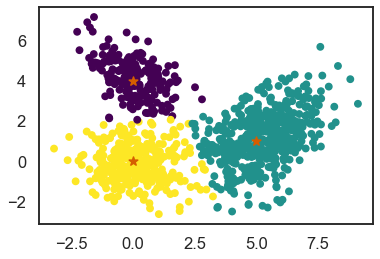

In [45]:
#plot_clustering(toy_data, toy_cluster_ids_fit, toy_means_fit, 'Toy dataset: GMM clusters')
#plot_clustering(toy_data, toy_cluster_ids_true, toy_means, 'Toy dataset: True clusters')

plot_clustering(toy_data, toy_cluster_ids_true, toy_means, 'Toy dataset: Ground truth')

In [47]:
#plot_clustering(toy_data, toy_cluster_ids_fit, toy_means_fit, 'Toy dataset: GMM clusters')
#plot_clustering(toy_data, toy_cluster_ids_true, toy_means, 'Toy dataset: True clusters')

Now apply your GMM implementation to the transcriptomics data using `n=50` clusters (as for the k-Means algorithm above). Use the PCs explaining 75% of the variance ```PCA_75_sklearn``` you computed above. Compare the result to the result of the k-Means algorithm and the original clustering labels provided by the authors. 

array([27, 18, 40, ...,  6,  6,  6], dtype=int64)

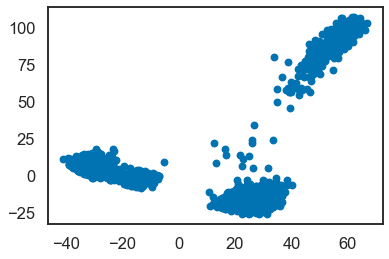

In [48]:

PCA_75_sklearn = compute_PCA_scores(tasic_1k['logCPM'], PCs_sklearn75)
X_scaled = PCA_75_sklearn

from sklearn.decomposition import PCA
import pandas as pd


ndimensions = 2

pca = PCA(n_components=ndimensions)
pca.fit(X_scaled)
X_pca_array = pca.transform(X_scaled)
X_pca = pd.DataFrame(X_pca_array, columns=['PC1','PC2']) # PC=principal component
X_pca.sample(5)

plt.scatter(X_pca["PC1"], X_pca["PC2"], s=40, cmap='viridis')

from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=50)
gmm.fit(X_scaled)

# predict the cluster for each data point
y_cluster_gmm = gmm.predict(X_scaled)
y_cluster_gmm

#plt.scatter(X_pca["PC1"], X_pca["PC2"], s=40, cmap='viridis')

Plot your results as cluster labels in the tSNE map and compare it to the original cluster labels and k-Means predictions. Describe your results.

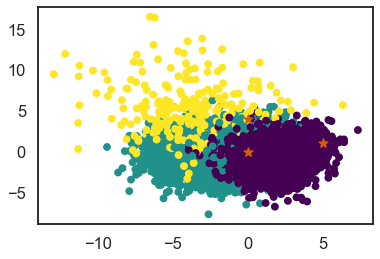

In [49]:
# plot results of GMM, k-Means and original cluster labels
# ---------------- INSERT CODE ----------------------
plot_clustering(PCA_75_sklearn, toy_cluster_ids_true, toy_means, 'Toy dataset: Kmean')
# ---------------- END CODE ------------------------- 